In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import random

In [2]:
def generate_rook_blocker_mask(square):
    mask = 0
    rank = square // 8
    file = square % 8

    # Ruch w górę
    for r in range(rank + 1, 7):
        mask |= 1 << (r * 8 + file)
    # Ruch w dół
    for r in range(rank - 1, 0, -1):
        mask |= 1 << (r * 8 + file)
    # Ruch w prawo
    for f in range(file + 1, 7):
        mask |= 1 << (rank * 8 + f)
    # Ruch w lewo
    for f in range(file - 1, 0, -1):
        mask |= 1 << (rank * 8 + f)

    return mask

def generate_blocker_variations(mask):
    bits = [i for i in range(64) if (mask >> i) & 1]
    variation_count = 1 << len(bits)
    blockers = []

    for index in range(variation_count):
        blocker = 0
        for i, bit in enumerate(bits):
            if (index >> i) & 1:
                blocker |= 1 << bit
        blockers.append(blocker)
    return blockers

def compute_rook_attacks(square, blockers):
    attacks = 0
    rank = square // 8
    file = square % 8

    # W górę
    for r in range(rank + 1, 8):
        sq = r * 8 + file
        attacks |= 1 << sq
        if blockers & (1 << sq): break
    # W dół
    for r in range(rank - 1, -1, -1):
        sq = r * 8 + file
        attacks |= 1 << sq
        if blockers & (1 << sq): break
    # W prawo
    for f in range(file + 1, 8):
        sq = rank * 8 + f
        attacks |= 1 << sq
        if blockers & (1 << sq): break
    # W lewo
    for f in range(file - 1, -1, -1):
        sq = rank * 8 + f
        attacks |= 1 << sq
        if blockers & (1 << sq): break

    return attacks


def generate_rook_attack_table(square):
    mask = generate_rook_blocker_mask(square)
    blocker_variations = generate_blocker_variations(mask)

    attack_table = {}

    for blockers in blocker_variations:
        attack = compute_rook_attacks(square, blockers)
        attack_table[blockers] = attack

    return attack_table

In [3]:
rook_almost_magic_table = []

for i in range(64):
    rook_almost_magic_table.append(generate_rook_attack_table(i))

In [4]:
def generate_bishop_blocker_mask(square):
    mask = 0
    rank = square // 8
    file = square % 8

    # Ruch w górę prawo
    piece_bitboard = 1 << square
    for i in range(1, min(7 - rank, 7 - file)):
        piece_bitboard = piece_bitboard << 9
        mask |= piece_bitboard
    # Ruch w górę lewo
    piece_bitboard = 1 << square
    for i in range(1, min(7 - rank, file)):
        piece_bitboard = piece_bitboard << 7
        mask |= piece_bitboard

    # Ruch w dół lewo
    piece_bitboard = 1 << square
    for i in range(1, min(rank, 7 - file)):
        piece_bitboard = piece_bitboard >> 7
        mask |= piece_bitboard

    # # Ruch w dół prawo
    piece_bitboard = 1 << square
    for i in range(1, min(rank, file)):
        piece_bitboard = piece_bitboard >> 9
        mask |= piece_bitboard

    return mask

def compute_bishop_attacks(square, blockers):
    attacks = 0
    rank = square // 8
    file = square % 8

    # Ruch w górę prawo
    piece_bitboard = 1 << square
    for i in range(1, min(8 - rank, 8 - file)):
        piece_bitboard = piece_bitboard << 9
        attacks |= piece_bitboard
        if blockers & piece_bitboard: break
    # Ruch w górę lewo
    piece_bitboard = 1 << square
    for i in range(1, min(8 - rank, file + 1)):
        piece_bitboard = piece_bitboard << 7
        attacks |= piece_bitboard
        if blockers & piece_bitboard: break


    # Ruch w dół lewo
    piece_bitboard = 1 << square
    for i in range(1, min(rank + 1, 8 - file)):
        piece_bitboard = piece_bitboard >> 7
        attacks |= piece_bitboard
        if blockers & piece_bitboard: break

    # # Ruch w dół prawo
    piece_bitboard = 1 << square
    for i in range(1, min(rank + 1, file + 1)):
        piece_bitboard = piece_bitboard >> 9
        attacks |= piece_bitboard
        if blockers & piece_bitboard: break

    return attacks


def generate_bishop_attack_table(square):
    mask = generate_bishop_blocker_mask(square)
    blocker_variations = generate_blocker_variations(mask)

    attack_table = {}

    for blockers in blocker_variations:
        attack = compute_bishop_attacks(square, blockers)
        attack_table[blockers] = attack

    return attack_table

In [5]:
bishop_almost_magic_table = []

for i in range(64):
    bishop_almost_magic_table.append(generate_bishop_attack_table(i))

In [6]:
def print_board(square=None, blockers=0, attacks=0, ax=None, piece = '♖'):
    if ax is None:
        fig, ax = plt.subplots()

    for i in range(8):
        for j in range(8):
            index = i * 8 + j
            square_color = 'white' if (i + j) % 2 == 0 else 'gray'

            if (attacks >> index) & 1:
                square_color = 'red'

            rect = patches.Rectangle((j, i), 1, 1, linewidth=1, edgecolor='black', facecolor=square_color)
            ax.add_patch(rect)

            ax.text(j + 0.15, i + 0.2, str(index), ha='center', va='center', fontsize=6)

            if (blockers >> index) & 1:
                ax.text(j + 0.5, i + 0.45, '•', ha='center', va='center', fontsize=18)
            if square == index:
                ax.text(j + 0.5, i + 0.4, piece, ha='center', va='center', fontsize=18, color='black')

    ax.set_xlim(0, 8)
    ax.set_ylim(0, 8)
    ax.set_aspect('equal')
    ax.axis('off')


def show_random_positions(n, magic_moves, piece = '♖'):
    fig, axs = plt.subplots(n, 5, figsize=(16, 3 * n))
    axs = axs.reshape((n, 5))  # gwarantuje tablicę 2D

    random_squares = random.sample(range(64), n)

    for row, square in enumerate(random_squares):

        blockers_list = list(magic_moves[square].keys())
        chosen = random.sample(blockers_list, min(5, len(blockers_list)))

        for col in range(5):
            blockers = chosen[col]
            attacks = magic_moves[square][blockers]
            print_board(square, blockers, attacks, ax=axs[row, col], piece=piece)

    plt.tight_layout()
    plt.show()


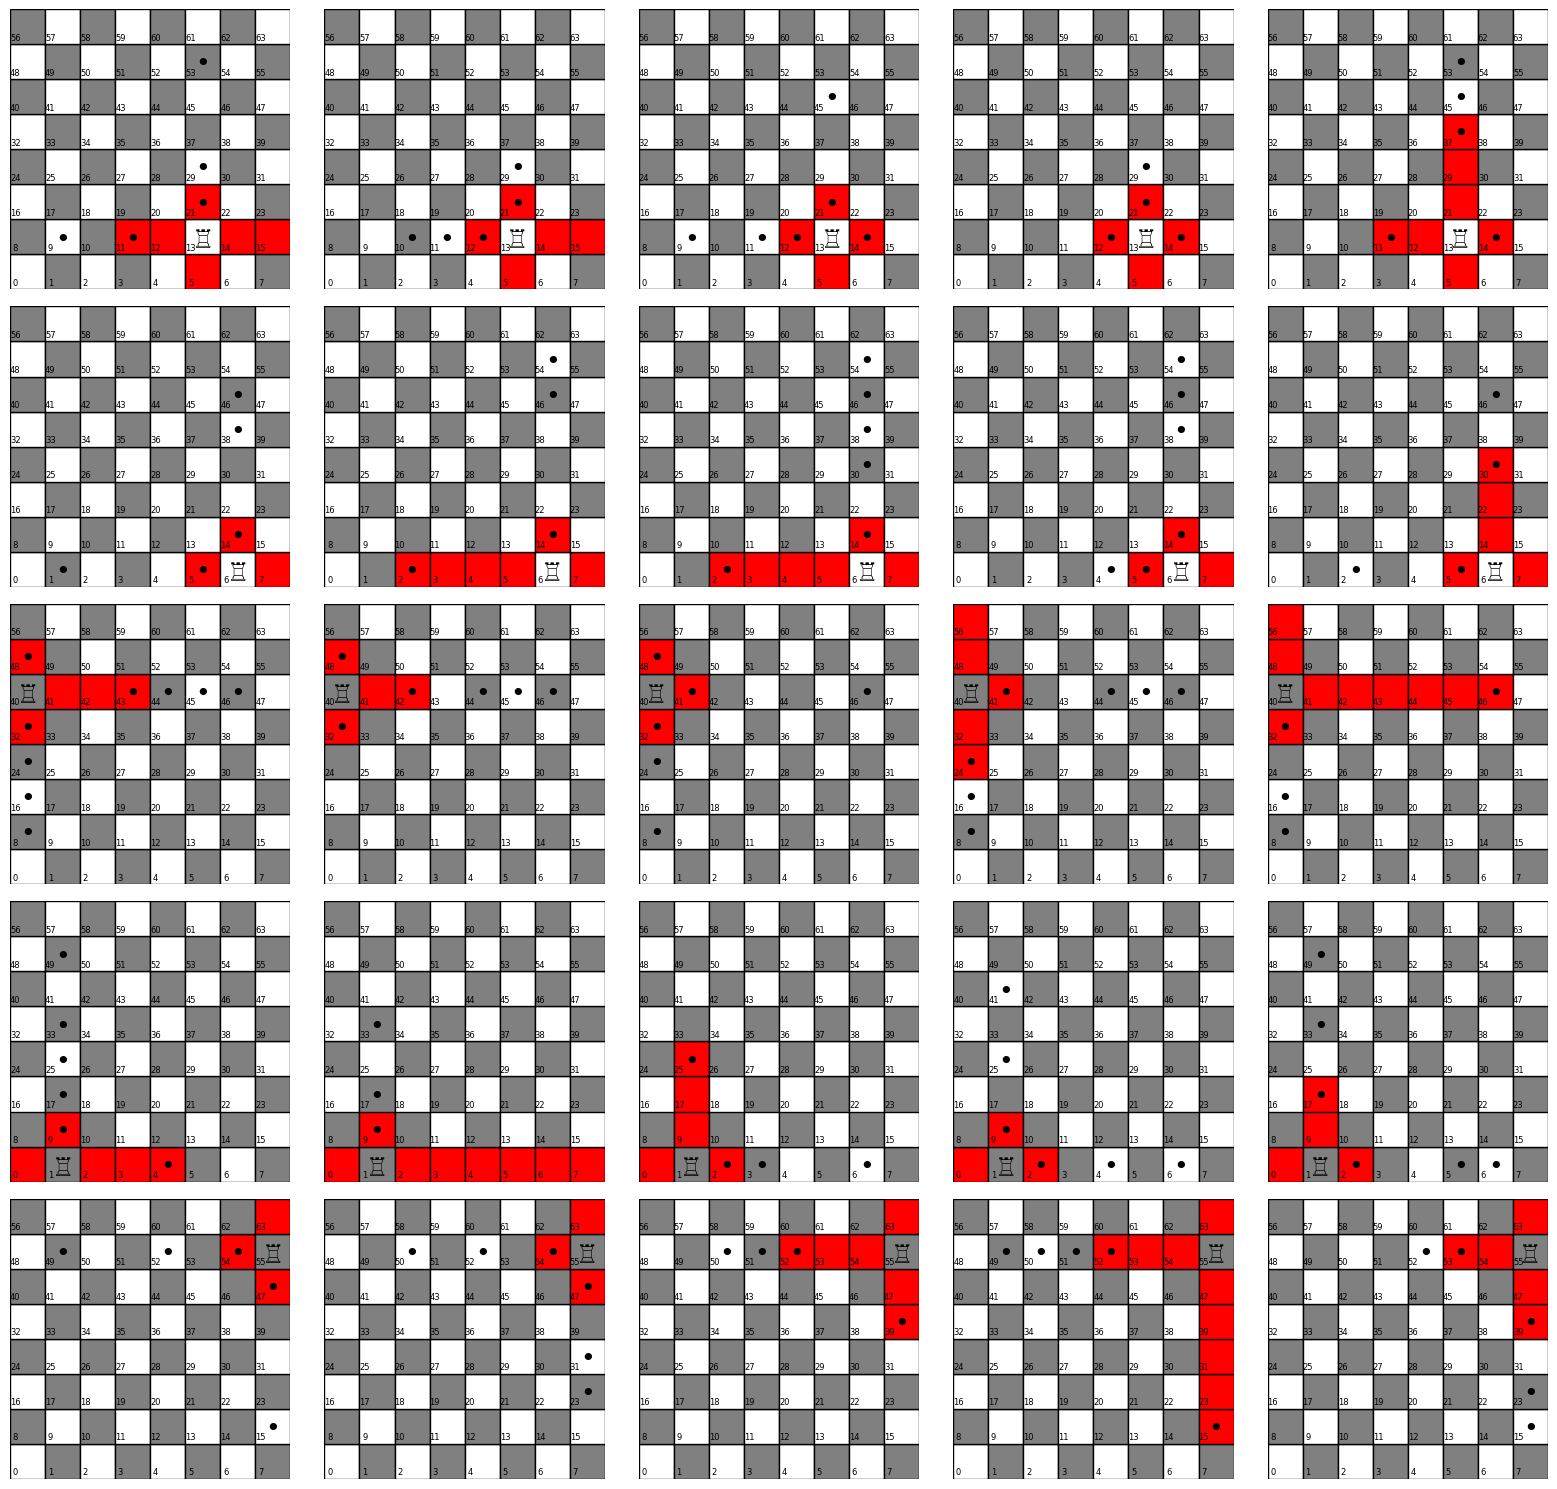

In [7]:
show_random_positions(5, rook_almost_magic_table)

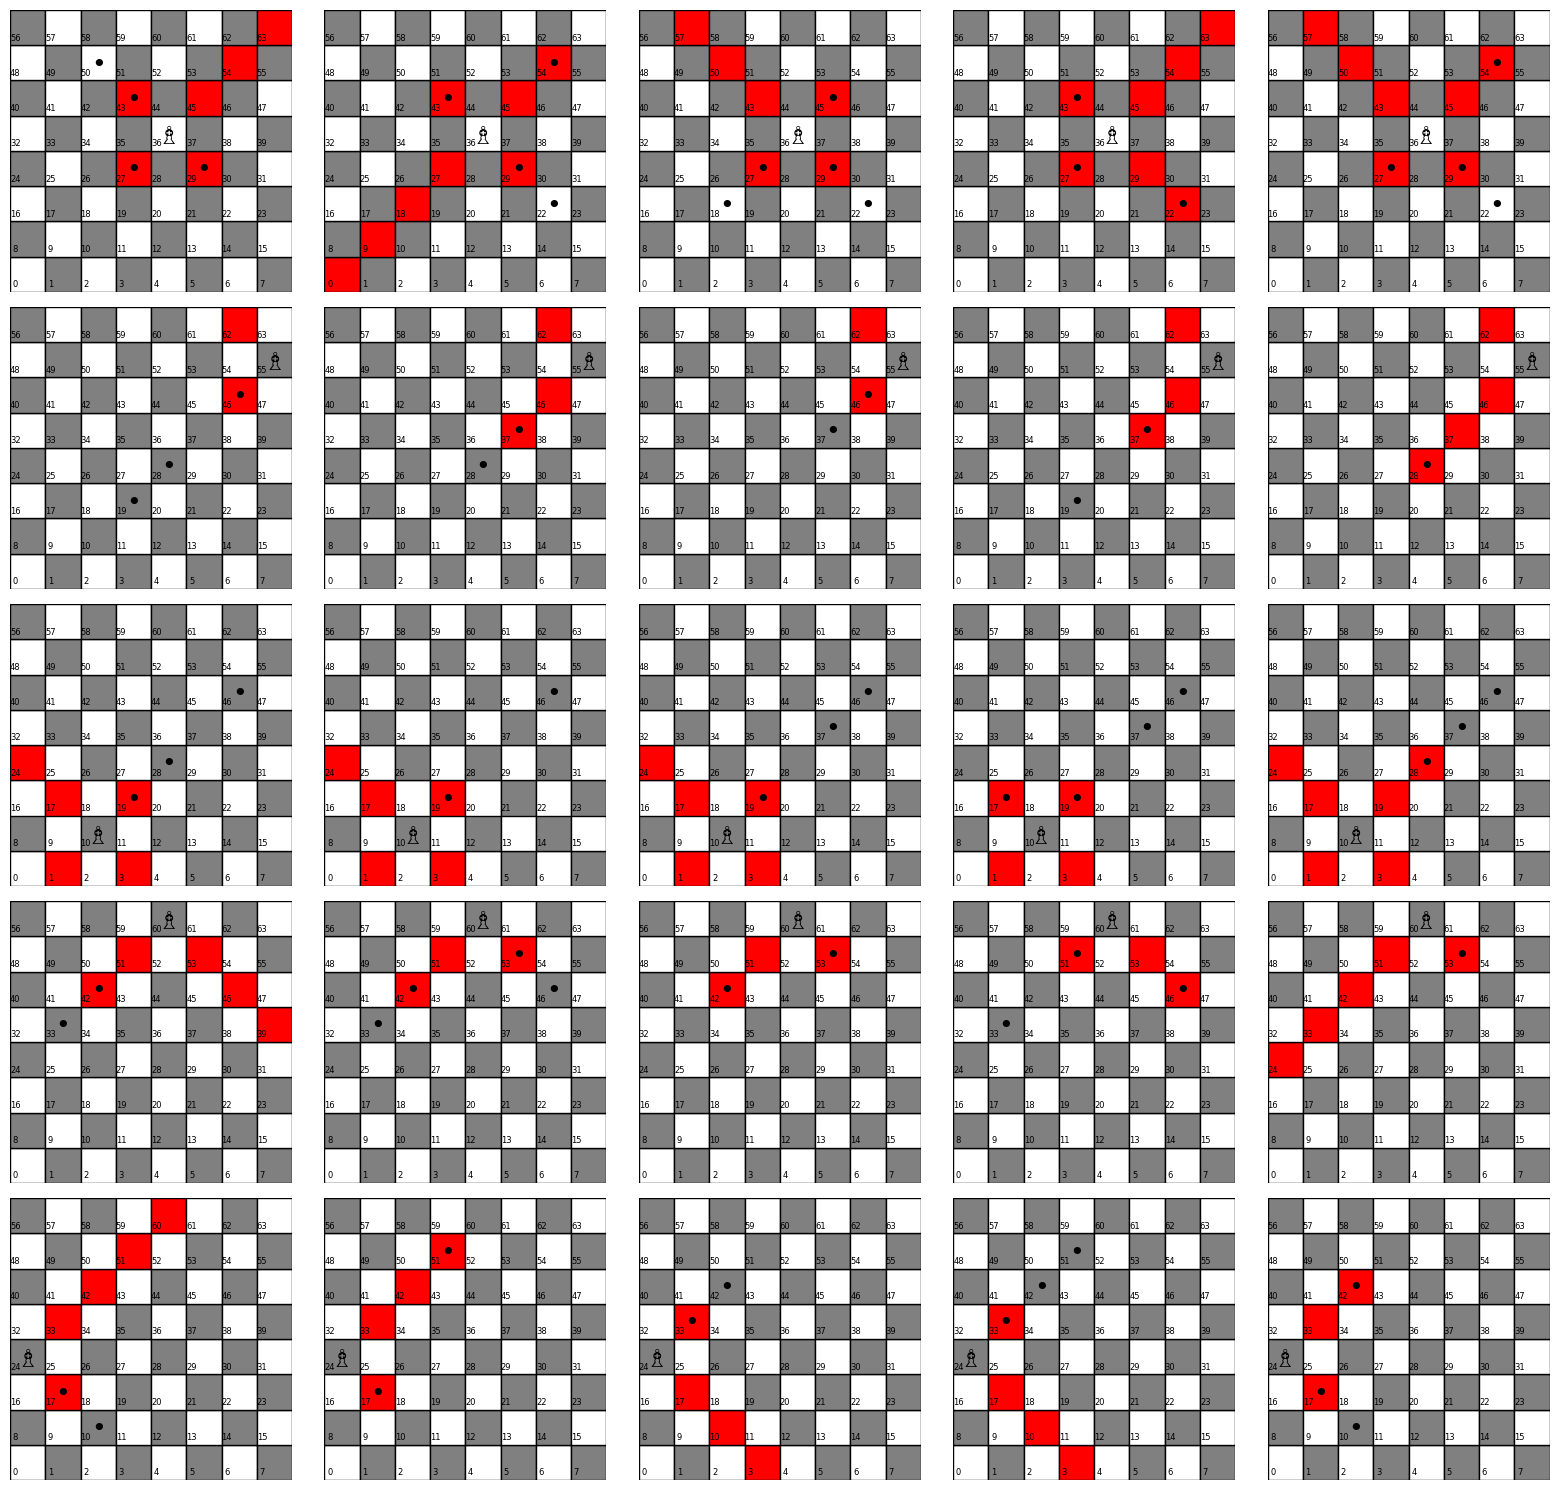

In [8]:
show_random_positions(5, bishop_almost_magic_table,'♗')

In [60]:
def to_cpp_u64(x):
    return f"0x{x:016X}ULL"

def generate_cpp_rook_blocker_masks():
    masks = [generate_rook_blocker_mask(i) for i in range(64)]
    return masks

def generate_cpp_bishop_blocker_masks():
    masks = [generate_bishop_blocker_mask(i) for i in range(64)]
    return masks


def generate_cpp_rook_header(rook_table):
    rook_masks = [generate_rook_blocker_mask(i) for i in range(64)]

def generate_cpp_rook_header(rook_table):
    def to_cpp_u64(x):
        return f"0x{x:016X}ULL"

    rook_masks = [generate_rook_blocker_mask(i) for i in range(64)]

    with open("RookMagicBitboards.h", "w") as f:
        f.write("#pragma once\n")
        f.write("#include <unordered_map>\n#include <array>\n#include \"../BitboardsUtils.h\"\n\n")
        f.write("class RookMagicBitboards\n{\npublic:\n")

        f.write("\tstatic u64 GetMovesMask(int square, u64 blockers)\n\t{\n")
        f.write("\t\tconst auto& dict = m_MovesDictionary[square];\n")
        f.write("\t\tauto it = dict.find(blockers);\n")
        f.write("\t\treturn it != dict.end() ? it->second : 0;\n")
        f.write("\t}\n\n")

        f.write("\tstatic u64 GetBlockersMask(int square)\n\t{\n")
        f.write("\t\treturn m_BlockerMasks[square];\n\t}\n")

        f.write("\nprivate:\n")
        f.write("\tstatic constexpr std::array<u64, 64> m_BlockerMasks = {\n\t\t")
        for i, mask in enumerate(rook_masks):
            f.write(to_cpp_u64(mask))
            if i != 63:
                f.write(", ")
                if (i + 1) % 2 == 0:
                    f.write("\n\t\t")
            else:
                f.write("\n\t")
        f.write("};\n\n")

        f.write("\tstatic constexpr std::array<std::unordered_map<u64, u64>, 64> m_MovesDictionary = {\n")
        for square_table in rook_table:
            f.write("\t\t{\n")
            for blocker, attack in square_table.items():
                f.write(f"\t\t\t{{{to_cpp_u64(blocker)}, {to_cpp_u64(attack)}}},\n")
            f.write("\t\t},\n")
        f.write("\t};\n\n")

        f.write("};\n")


def generate_cpp_bishop_header(bishop_table):
    bishop_masks = [generate_bishop_blocker_mask(i) for i in range(64)]

    with open("BishopMagicBitboards.h", "w") as f:
        f.write("#pragma once\n")
        f.write("#include <unordered_map>\n#include <array>\n#include \"../BitboardsUtils.h\"\n\n")
        f.write("class BishopMagicBitboards\n{\npublic:\n")

        f.write("\tstatic u64 GetMovesMask(int square, u64 blockers)\n\t{\n")
        f.write("\t\tconst auto& dict = m_MovesDictionary[square];\n")
        f.write("\t\tauto it = dict.find(blockers);\n")
        f.write("\t\treturn it != dict.end() ? it->second : 0;\n")
        f.write("\t}\n\n")


        f.write("\tstatic u64 GetBlockersMask(int square)\n\t{\n")
        f.write("\t\treturn m_BlockerMasks[square];\n\t}\n")
        f.write("\nprivate:\n")
        f.write("\tstatic constexpr std::array<u64, 64> m_BlockerMasks = {\n\t\t")
        for i, mask in enumerate(bishop_masks):
            f.write(to_cpp_u64(mask))
            if i != 63:
                f.write(", ")
                if (i + 1) % 2 == 0:
                    f.write("\n\t\t")
            else:
                f.write("\n\t")
        f.write("};\n\n")

        f.write("    static constexpr std::array<std::unordered_map<u64, u64>, 64> m_MovesDictionary = {\n")
        for square_table in bishop_table:
            f.write("        {\n")
            for blocker, attack in square_table.items():
                f.write(f"            {{{to_cpp_u64(blocker)}, {to_cpp_u64(attack)}}},\n")
            f.write("        },\n")
        f.write("    };\n\n")



        f.write("};\n")


In [61]:
generate_cpp_rook_header(rook_almost_magic_table)

In [62]:
generate_cpp_bishop_header(bishop_almost_magic_table)